In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers, models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print(os.getenv("CUDA_VISIBLE_DEVICES"))

1


In [3]:
train_dir = r'./melanoma_cancer_dataset/train'
test_dir = r'./melanoma_cancer_dataset/test'

batch_size = 32
img_height = 300
img_width = 300

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9605 files belonging to 2 classes.
Using 7684 files for training.
Found 9605 files belonging to 2 classes.
Using 1921 files for validation.
Found 1000 files belonging to 2 classes.


In [4]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


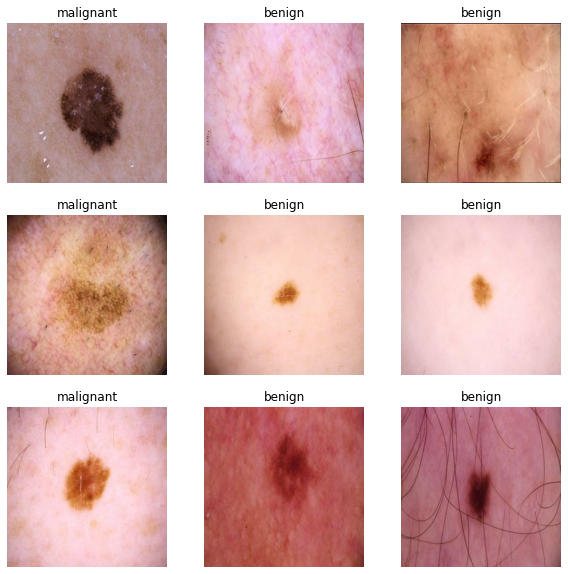

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
img_shape=(img_height, img_width, 3)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

batch_normalizer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)
dense_layer_1 = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')
dropout_1 = Dropout(rate=.5, seed=123)
dense_layer_2 = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')
dropout_2 = Dropout(0.5, seed=123)
prediction_layer = Dense(1, activation='sigmoid')

custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    verbose=1,
    mode='max',
    restore_best_weights=True
)

lr=.0001

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

with strategy.scope():
    base_model=tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
    ) 

    base_model.trainable='False'
    
    model = models.Sequential([
        base_model,
        batch_normalizer,
        dense_layer_1,
        dropout_1,
        dense_layer_2,
        dropout_2,
        prediction_layer
    ])
    
    model.compile(Adamax(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

171458560/171446536 [==============================] - 3s 0us/step


In [9]:
history=model.fit(x=train_ds,  epochs=40, verbose=1, validation_data=val_ds,
               validation_steps=None,  shuffle=False,  initial_epoch=0, callbacks = custom_early_stopping)

Epoch 1/40
241/241 [==============================] - 554s 2s/step - loss: 24.5744 - accuracy: 0.7695 - val_loss: 22.7698 - val_accuracy: 0.8397
Epoch 2/40
241/241 [==============================] - 509s 2s/step - loss: 20.8627 - accuracy: 0.8689 - val_loss: 20.1339 - val_accuracy: 0.8886
Epoch 3/40
241/241 [==============================] - 509s 2s/step - loss: 18.0331 - accuracy: 0.9107 - val_loss: 16.9529 - val_accuracy: 0.9073
Epoch 4/40
241/241 [==============================] - 508s 2s/step - loss: 15.5772 - accuracy: 0.9361 - val_loss: 15.1668 - val_accuracy: 0.9058
Epoch 5/40
241/241 [==============================] - 509s 2s/step - loss: 13.4105 - accuracy: 0.9612 - val_loss: 12.5853 - val_accuracy: 0.9141
Epoch 6/40
241/241 [==============================] - 508s 2s/step - loss: 11.4578 - accuracy: 0.9820 - val_loss: 10.9363 - val_accuracy: 0.9141
Epoch 7/40
241/241 [==============================] - 508s 2s/step - loss: 9.6741 - accuracy: 0.9944 - val_loss: 9.3706 - val_accu

In [10]:
model.evaluate(test_ds)

32/32 [==============================] - 19s 583ms/step - loss: 12.6804 - accuracy: 0.9100


[12.68037223815918, 0.9100000262260437]